In [1]:
# global configuration variables
dbFilename = r"voice-memos-5-24.db"

# source folder for archive files
siblingSourceFolder = "corpus"

In [2]:
import essentia
from essentia import Pool, array
import essentia.streaming as ess
import essentia.standard as stan
from pylab import *
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Audio

## SQLite interface

In [3]:
import sqlite3
from sqlite3 import Error


def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
#     try:
    conn = sqlite3.connect(db_file)
    print(sqlite3.version)
    return conn
#     except Error as e:
#         print(e)
        
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def create_archive_file(conn, archive_file):
    """
    Create a new archive_file into the archive_file table
    :param conn:
    :param archive_file:
    :return: project id
    """
    sql = ''' INSERT INTO archive_files(name, durationSeconds)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.execute(sql, archive_file)
    conn.commit()
    return cur.lastrowid

def create_sound_object(conn, sound_object):
    """
    Create a new sound_object
    :param conn:
    :param sound_object:
    :return: sound_object id
    """

    sql = ''' INSERT INTO sound_objects(durationSeconds,effectiveDuration,rms,loudness,pitch,pitchConfidence,flatness,centroid,variance,path,archive_file_id,archive_file_duration_seconds,start,end)
              VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, sound_object)
    conn.commit()

    return cur.lastrowid

def create_descriptor_stats(conn, stats):
    """
    Create a new task
    :param conn:
    :param stats:
    :return: stats id
    """

    sql = ''' INSERT INTO stats(descriptor, avg, stddev, min, max)
              VALUES(?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, stats)
    conn.commit()

    return cur.lastrowid

def update_stats(conn, stats):
    sql = ''' UPDATE stats
              SET descriptor = ?
              WHERE id = ?'''
    cur = conn.cursor()
    cur.execute(sql, stats)
    conn.commit()

def delete_stats(conn):
    """
    Delete stats records
    :param conn:
    """

    sql = ''' DELETE FROM stats '''
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()

## SQLite user-defined functions

In [4]:
import sqlite3
import math

def create_stats(descriptorName,avg,stddev,descriptorMin,descriptorMax):
    statsRecord = (
        descriptorName,
        avg,
        stddev,
        descriptorMin,
        descriptorMax
    )
    return create_descriptor_stats(db, statsRecord)

# https://www.alexforencich.com/wiki/en/scripts/python/stdev
class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1
 
    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1
 
    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))
    
class HistogramFunc:
    def __init__(self):
        self.d = np.empty(1)

    def step(self, value):
        self.d = np.append(self.d, value)
 
    def finalize(self):
        self.d = np.delete(self.d, 0)
        
        stddev = np.std(self.d)
        mean = np.mean(self.d)
        descMin = np.amin(self.d)
        descMax = np.amax(self.d)

        print("mean, std")
        print(mean)
        print(stddev)
        
        print("min")
        print(descMin)
        print(np.argmin(self.d))

        
        print("max")
        print(descMax)
        print(np.argmax(self.d))

        range_low = mean - 2*stddev;
        range_high = mean + 2*stddev;
        if range_low < 0:
            range_low = 0
        range_tuple = (range_low,range_high)
        print(range_tuple)

        plt.hist(self.d, bins = 40, range = range_tuple) 
        plt.title("Histogram") 
        plt.show()
        
        stats_id = create_stats("name", mean, stddev, descMin, descMax)
        
        return stats_id


## Create database and tables

In [5]:
db = create_connection(dbFilename)

sql_create_stats_table = """ CREATE TABLE stats (
                                    id integer PRIMARY KEY,
                                    descriptor text NOT NULL,
                                    avg float NOT NULL,
                                    stddev float NOT NULL,
                                    min float NOT NULL,
                                    max float NOT NULL
                                ); """

sql_create_archive_files_table = """ CREATE TABLE archive_files (
                                    id integer PRIMARY KEY,
                                    name text NOT NULL,
                                    durationSeconds float NOT NULL
                                ); """

sql_create_sound_objects_table = """CREATE TABLE sound_objects (
                                    id integer PRIMARY KEY,
                                    durationSeconds float NOT NULL,
                                    effectiveDuration float NOT NULL,
                                    rms float NOT NULL,
                                    loudness float NOT NULL,
                                    pitch float NOT NULL,
                                    pitchConfidence float NOT NULL,
                                    flatness float NOT NULL,
                                    centroid float NOT NULL,
                                    variance float NOT NULL,
                                    path text NOT NULL,
                                    archive_file_id integer NOT NULL,
                                    archive_file_duration_seconds float NOT NULL,
                                    start integer NOT NULL,
                                    end integer NOT NULL,
                                    FOREIGN KEY (archive_file_id) REFERENCES archive_files (id)
                                );"""

# create tables
if db is not None:
    # create stats table
    create_table(db, sql_create_stats_table)
    
    # create archive_files table
    create_table(db, sql_create_archive_files_table)

    # create sound_objects table
    create_table(db, sql_create_sound_objects_table)
else:
    print("Error! cannot create the database connection.")

2.6.0
table stats already exists
table archive_files already exists
table sound_objects already exists


In [6]:
def get_sound_objects_from_onsets(onset_positions, audio):

    sound_objects = []
    skipped = 0
    numOnsets = onset_positions.shape[0]
    if numOnsets == 1:
        return sound_objects;
    for i in range(numOnsets):
        if i == 0:
            continue

        nStart = int(sampleRate * onset_positions[i-1]) # previous onset sample
        nEnd = int(sampleRate * onset_positions[i]) # current onset sample

        if(nEnd-nStart) < sampleRate*0.15: # remove sounds that are shorter than 0.15 seconds
            continue
        if(nEnd-nStart) > sampleRate*10: # filter sounds that are longer than 10
            continue

        startFrame = int(nStart/hopSize) # loss of precision here
        endFrame = int(nEnd/hopSize)

        sound_object_data = {}
        sound_object_data["rms"] = stan.Mean()(pool["features.rms"][startFrame:endFrame])
        
        sound_object_data["loudness"] = stan.Mean()(pool["features.loudness"][startFrame:endFrame])

        #print("mean rms: " + str(stan.Mean()(pool["features.rms"][startFrame:endFrame])))
        #print("weighted rms: " + str(sound_object_data["rms"]))
             
        sound_object_data["flatness"] = energy_weighted_mean(pool["features.flatnessDB"], startFrame, endFrame)
        
        weighted_mean_centroid = energy_weighted_mean(pool["features.centroid"], startFrame, endFrame)
        centroid_frequency = weighted_mean_centroid * (sampleRate/2)
        centroid_mel = 1000 * math.log2(1 + centroid_frequency/1000)
        sound_object_data["centroid"] = centroid_mel
        
        sound_object_data["variance"] = energy_weighted_mean(pool["features.variance"], startFrame, endFrame)

        pitch_freq = pitch_confidence_weighted_mean(pool["features.pitch"], startFrame, endFrame)
        if pitch_freq < 1:
            pitch_freq = 0
        sound_object_data["pitch"] = 1000 * math.log2(1 + pitch_freq/1000)
        #print("mean pitch: " + str(stan.Mean()(pool["features.pitch"][startFrame:endFrame])))
        #print("weighted pitch: " + str(sound_object_data["pitch"]))
        
        sound_object_data["pitchConfidence"] = energy_weighted_mean(pool["features.pitchConfidence"], startFrame, endFrame)
        
        sound_object_data["audio"] = audio[nStart:nEnd]
        sound_object_data["start"] = nStart
        sound_object_data["end"] = nEnd
        
        if(nStart > len(audio)):
            skipped = skipped + 1
            continue

        sound_objects.append(sound_object_data)

    return sound_objects

def energy_weighted_mean(feature_vector, startFrame, endFrame):
    weights = pool["features.energy"][startFrame : endFrame]
    weighted_feature = feature_vector[startFrame : endFrame] * weights
    weighted_feature_sum = np.sum(weighted_feature)
    
    return float(weighted_feature_sum / np.sum(weights))

def pitch_confidence_weighted_mean(feature_vector, startFrame, endFrame):
    weights = pool["features.pitchConfidence"][startFrame : endFrame]
    weighted_feature = feature_vector[startFrame : endFrame] * weights
    weighted_feature_sum = np.sum(weighted_feature)
    
    return float(weighted_feature_sum / np.sum(weights))
    

In [7]:
# putting it all together
from pathlib import Path
from scipy.io.wavfile import write, read
import json

def write_archive_file_sound_objects_to_db(archive_file_name, sound_objects, archive_file_duration_in_seconds):
    # initialize an object to store data for the clip
    archive_file = (archive_file_name, archive_file_duration_in_seconds,)
    archive_file_id = create_archive_file(db, archive_file)

    # process each detected sound_object
    for i, sound_object in enumerate(sound_objects):
        sourcePath = Path(f"{siblingSourceFolder}/{archive_file_name}")
        durationSeconds = len(sound_object["audio"]) / sampleRate
        
        effectiveDuration = stan.EffectiveDuration()(sound_object["audio"])
        
        sound_object_attributes = (
            durationSeconds,
            effectiveDuration,
            sound_object["rms"],
            sound_object["loudness"],
            sound_object["pitch"],
            sound_object["pitchConfidence"],
            sound_object["flatness"],
            sound_object["centroid"],
            sound_object["variance"],
            str("/".join(sourcePath.parts)),
            archive_file_id,
            archive_file_duration_in_seconds,
            sound_object["start"],
            sound_object["end"]
        )

        create_sound_object(db, sound_object_attributes)

In [8]:
def already_processed(archive_file_name):
    cursor = db.cursor()
    rowsQuery = "SELECT Count(*) FROM archive_files where name = \"" + archive_file_name + "\";"
    cursor.execute(rowsQuery)
    return cursor.fetchone()[0] > 0

In [9]:
from datetime import datetime
import os
print("Loading extractor...")

count = 0;

standardLoader = stan.MonoLoader()
streamingLoader = ess.MonoLoader()

sampleRate=44100
frameSize=2048
hopSize=512

framecutter = ess.FrameCutter(frameSize=frameSize, hopSize=hopSize, silentFrames='noise')
windowing = ess.Windowing(type='hann')
c2p = ess.CartesianToPolar()
od1 = ess.OnsetDetection(method='hfc')
fft = ess.FFT()
pitch = ess.PitchYinFFT(frameSize=frameSize)
rms = ess.RMS()
loudness = ess.Loudness()
flatness = ess.FlatnessDB()
centroid = ess.Centroid()
variance = ess.Variance()
spectrum = ess.Spectrum()
energy = ess.Energy()
pool = Pool()

# Connect streaming algorithms
streamingLoader.audio >> framecutter.signal
framecutter.frame >> windowing.frame >> fft.frame
fft.fft >> c2p.complex
c2p.phase >> od1.phase
c2p.magnitude >> None

windowing.frame >> energy.array
energy.energy >> (pool, 'features.energy')

windowing.frame >> spectrum.frame
spectrum.spectrum >> od1.spectrum
od1.onsetDetection >> (pool, 'features.hfc')

windowing.frame >> rms.array
rms.rms >> (pool, 'features.rms')

windowing.frame >> loudness.signal
loudness.loudness >> (pool, 'features.loudness')

spectrum.spectrum >> pitch.spectrum
pitch.pitch >> (pool, 'features.pitch')
pitch.pitchConfidence >> (pool, 'features.pitchConfidence')

c2p.magnitude >> flatness.array
flatness.flatnessDB >> (pool, 'features.flatnessDB')

c2p.magnitude >> centroid.array
centroid.centroid >> (pool, 'features.centroid')

c2p.magnitude >> variance.array
variance.variance >> (pool, 'features.variance')

for archive_file_name in os.listdir(os.getcwd() + "/" + siblingSourceFolder):
    if (archive_file_name.endswith((".wav",".m4a",".aiff",".mp3",))):
        count = count + 1
        
        if already_processed(archive_file_name):
            print(str(count) + ": " + archive_file_name + " -- already processed, skipping")
            continue
        standardLoader.configure(filename=siblingSourceFolder + "/" + archive_file_name)
        audio = standardLoader()
        streamingLoader.configure(filename=siblingSourceFolder + "/" + archive_file_name)
        
        essentia.run(streamingLoader)

        # Phase 2: compute the actual onsets locations
        
        # NOTE This implementation depends on a frameRate of 44100.0/512.0
        onsets = stan.Onsets(frameRate=sampleRate/hopSize)

        onsets_hfc = onsets(# this algo expects a matrix, not a vector
            array([ pool['features.hfc'] ]),
            # you need to specify weights, but as there is only a single
            # function, it doesn't actually matter which weight you give it
            [ 1 ])
        
        sound_objects = get_sound_objects_from_onsets(onsets_hfc, audio)
        
        archive_file_duration_in_seconds = len(audio)/sampleRate
        write_archive_file_sound_objects_to_db(archive_file_name, sound_objects, archive_file_duration_in_seconds)
        
        print(str(count) + ": " + archive_file_name + " ✅ " + str(len(sound_objects)) + " sound objects")

        
        # clear pool for next run
        pool.clear()
        # flush the audio buffer variable
        del audio



Loading extractor...
1: 20130320 202635.wav -- already processed, skipping
2: 20130322 165235.wav -- already processed, skipping
3: 20130322 165441.wav -- already processed, skipping
4: 20130327 015249.wav -- already processed, skipping
5: 20130412 010230.wav -- already processed, skipping
6: 20130416 123132.wav -- already processed, skipping
7: 20130426 185811.wav -- already processed, skipping
8: 20130504 102258.wav -- already processed, skipping
9: 20130505 083102.wav -- already processed, skipping
10: 20130505 101013.wav -- already processed, skipping
11: 20130505 101120.wav -- already processed, skipping
12: 20130508 170839.wav -- already processed, skipping
13: 20130524 223102.wav -- already processed, skipping
14: 20130615 235510.wav -- already processed, skipping
15: 20130619 224840.wav -- already processed, skipping
16: 20130628 235644.wav -- already processed, skipping
17: 20130629 175226.wav -- already processed, skipping
18: 20130721 004527.wav -- already processed, skippin

186: 20140408 204116.wav -- already processed, skipping
187: 20140409 003944 1.wav -- already processed, skipping
188: 20140409 185659 1.wav -- already processed, skipping
189: 20140409 185730 1.wav -- already processed, skipping
190: 20140410 122724 1.wav -- already processed, skipping
191: 20140410 195903.wav -- already processed, skipping
192: 20140410 211419 1.wav -- already processed, skipping
193: 20140410 221052.wav -- already processed, skipping
194: 20140410 224002 1.wav -- already processed, skipping
195: 20140413 190022 1.wav -- already processed, skipping
196: 20140415 204938.wav -- already processed, skipping
197: 20140415 205353.wav -- already processed, skipping
198: 20140416 200841.wav -- already processed, skipping
199: 20140422 101957 1.wav -- already processed, skipping
200: 20140422 102555 1.wav -- already processed, skipping
201: 20140422 164648.wav -- already processed, skipping
202: 20140422 164821.wav -- already processed, skipping
203: 20140422 184420.wav -- al

337: 20140725 144532.wav -- already processed, skipping
338: 20140725 144712.wav -- already processed, skipping
339: 20140725 184039.wav -- already processed, skipping
340: 20140727 140301.wav -- already processed, skipping
341: 20140727 151033.wav -- already processed, skipping
342: 20140728 232616.wav -- already processed, skipping
343: 20140728 232744.wav -- already processed, skipping
344: 20140728 232926.wav -- already processed, skipping
345: 20140729 193506.wav -- already processed, skipping
346: 20140731 184802.wav -- already processed, skipping
347: 20140731 190818.wav -- already processed, skipping
348: 20140731 200745.wav -- already processed, skipping
349: 20140731 201215.wav -- already processed, skipping
350: 20140802 161033.wav -- already processed, skipping
351: 20140803 194251.wav -- already processed, skipping
352: 20140804 012437.wav -- already processed, skipping
353: 20140804 033008.wav -- already processed, skipping
354: 20140804 040503.wav -- already processed, s

519: 20150818 220558.wav -- already processed, skipping
520: 20150822 100926.wav -- already processed, skipping
521: 20150823 000958.wav -- already processed, skipping
522: 20150905 214543.wav -- already processed, skipping
523: 20150915 105932.wav -- already processed, skipping
524: 20150916 175026.wav -- already processed, skipping
525: 20150916 211455.wav -- already processed, skipping
526: 20150917 122809.wav -- already processed, skipping
527: 20150918 075022.wav -- already processed, skipping
528: 20150918 083732.wav -- already processed, skipping
529: 20150918 222614.wav -- already processed, skipping
530: 20150920 204744.wav -- already processed, skipping
531: 20150920 210811.wav -- already processed, skipping
532: 20150921 070336.wav -- already processed, skipping
533: 20150921 083253.wav -- already processed, skipping
534: 20150921 135220.wav -- already processed, skipping
535: 20150922 201004.wav -- already processed, skipping
536: 20150923 145329.wav -- already processed, s

682: 201604-Dagnolo_Wedding_March_1.m4a -- already processed, skipping
683: 201604-Esteem_Lucy_Agriculture_by_Paul.m4a -- already processed, skipping
684: 201604-Flower_Suite_Intro.m4a -- already processed, skipping
685: 201604-Flower_intro_hum.m4a -- already processed, skipping
686: 201604-Had_It_Vox_Ideas.m4a -- already processed, skipping
687: 201604-Levad_On_Deck_By_Paul.m4a -- already processed, skipping
688: 201604-Matt_Is_Straight_Up_Hm.m4a -- already processed, skipping
689: 201604-My_Family_Is_Thirsty_For_Life.m4a -- already processed, skipping
690: 201604-New_Recording_283.m4a -- already processed, skipping
691: 201604-Omas_Song_Intro_On_Accordion.m4a -- already processed, skipping
692: 201604-Omas_sunset.m4a -- already processed, skipping
693: 201604-P&S_Suite_Intro.m4a -- already processed, skipping
694: 201604-Park_March_Piano.m4a -- already processed, skipping
695: 201604-Pay_The_Take_U_Take.m4a -- already processed, skipping
696: 201604-Piano_Compresssssssss_8ths.m4a -- 

813: 201610-Jammy_Jelly_Prep.m4a ✅ 923 sound objects
814: 201610-Mstorm.m4a ✅ 655 sound objects
815: 201610-New_Recording_314.m4a ✅ 57 sound objects
816: 201610-New_Recording_315.m4a ✅ 162 sound objects
817: 201610-New_Recording_316.m4a ✅ 93 sound objects
818: 201610-New_Recording_317.m4a ✅ 4 sound objects
819: 201610-New_Recording_318.m4a ✅ 115 sound objects
820: 201610-New_Recording_319.m4a ✅ 4201 sound objects
821: 201610-New_Recording_320.m4a ✅ 230 sound objects
822: 201610-New_Recording_321.m4a ✅ 53 sound objects
823: 201610-Ok_Weird_Sample_This.m4a ✅ 505 sound objects
824: 201610-Plastic_Fidgeting.m4a ✅ 110 sound objects
825: 201610-Tv_Theme_Show.m4a ✅ 275 sound objects
826: 201610-Waaaaat.m4a ✅ 201 sound objects
827: 201610-Welcome_October_16.m4a ✅ 363 sound objects
828: 201610-Yum_Pum_Pum.m4a ✅ 27 sound objects
829: 201610-together_Inspiration.m4a ✅ 1690 sound objects
830: 201611-All_U_Wanted_Was_Change_In_The_World.m4a ✅ 348 sound objects
831: 201611-Ambient_Rolls_Into_Glassy_

2.6.0
📊 durationSeconds 📈
mean, std
0.412906864784
0.495559035406
min
0.150861678005
15460
max
9.93811791383
227479
(0, 1.4040249355961452)


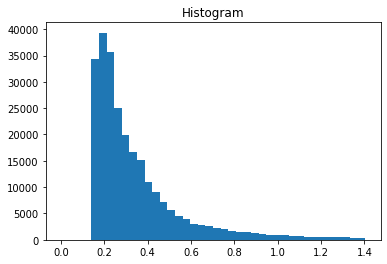

📊 effectiveDuration 📈
mean, std
0.0407148490169
0.0411073298205
min
4.53514730907e-05
108850
max
1.88281178474
125712
(0, 0.12292950865785365)


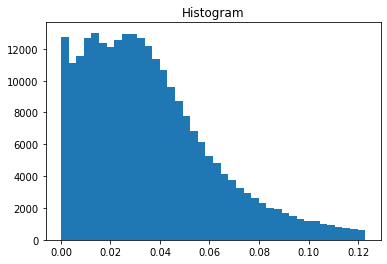

📊 rms 📈
mean, std
0.000119110187104
0.000104484933496
min
3.06352376356e-07
209043
max
0.000906559987925
124877
(0, 0.00032808005409695827)


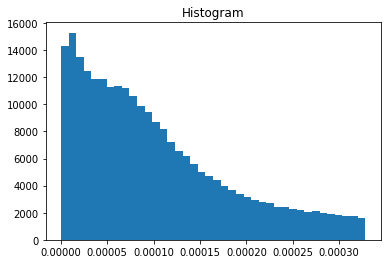

📊 loudness 📈
mean, std
0.00108897182206
0.00121915747341
min
3.10072579168e-07
209043
max
0.0138542419299
124877
(0, 0.0035272867688866468)


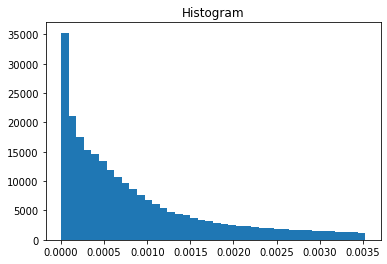

📊 pitch 📈
mean, std
439.442389088
367.534517122
min
86.7706604216
196859
max
3906.6572659
91716
(0, 1174.5114233311442)


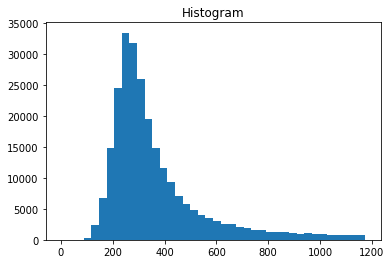

📊 flatness 📈
mean, std
0.298105271372
0.113950431357
min
0.041137676686
17503
max
1.0
184873
(0.070204408657041639, 0.52600613408684094)


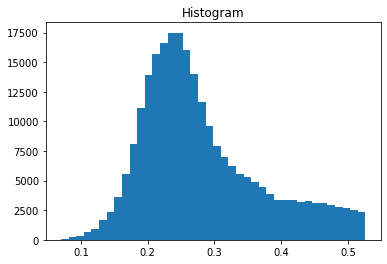

📊 centroid 📈
mean, std
1597.73351964
565.681146458
min
380.6613226
184779
max
3675.01454145
92394
(466.37122672561736, 2729.0958125583006)


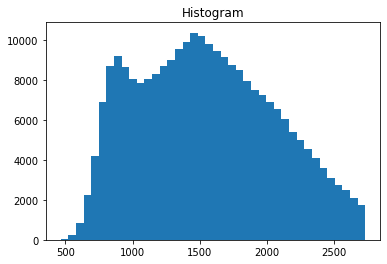

📊 variance 📈
mean, std
7.67220041837e-05
0.000110044802746
min
1.25748397806e-10
209043
max
0.00163681188133
124877
(0, 0.00029681160967513141)


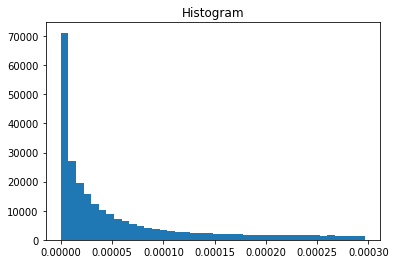

In [10]:
db = create_connection(dbFilename)
db.create_aggregate("stdev", 1, StdevFunc)
db.create_aggregate("histogram", 1, HistogramFunc)

 
def stats(column_name, conn):
    print("📊 %s 📈" % column_name)
    cur = db.cursor()
    cur.execute("select histogram(%s) from sound_objects" %column_name)
    stats_id = cur.fetchone()[0]
    stats_record = (column_name, stats_id)
    update_stats(conn, stats_record)
    
    
delete_stats(db)

stats("durationSeconds", db)
stats("effectiveDuration", db)
stats("rms", db)
stats("loudness", db)
stats("pitch", db)
stats("flatness", db)
stats("centroid", db)
stats("variance", db)
